# Chapter 4 - 文本分类
- 使用 表示类模型（BERT/特征抽取类）进行分类
- 使用 生成模型进行分类

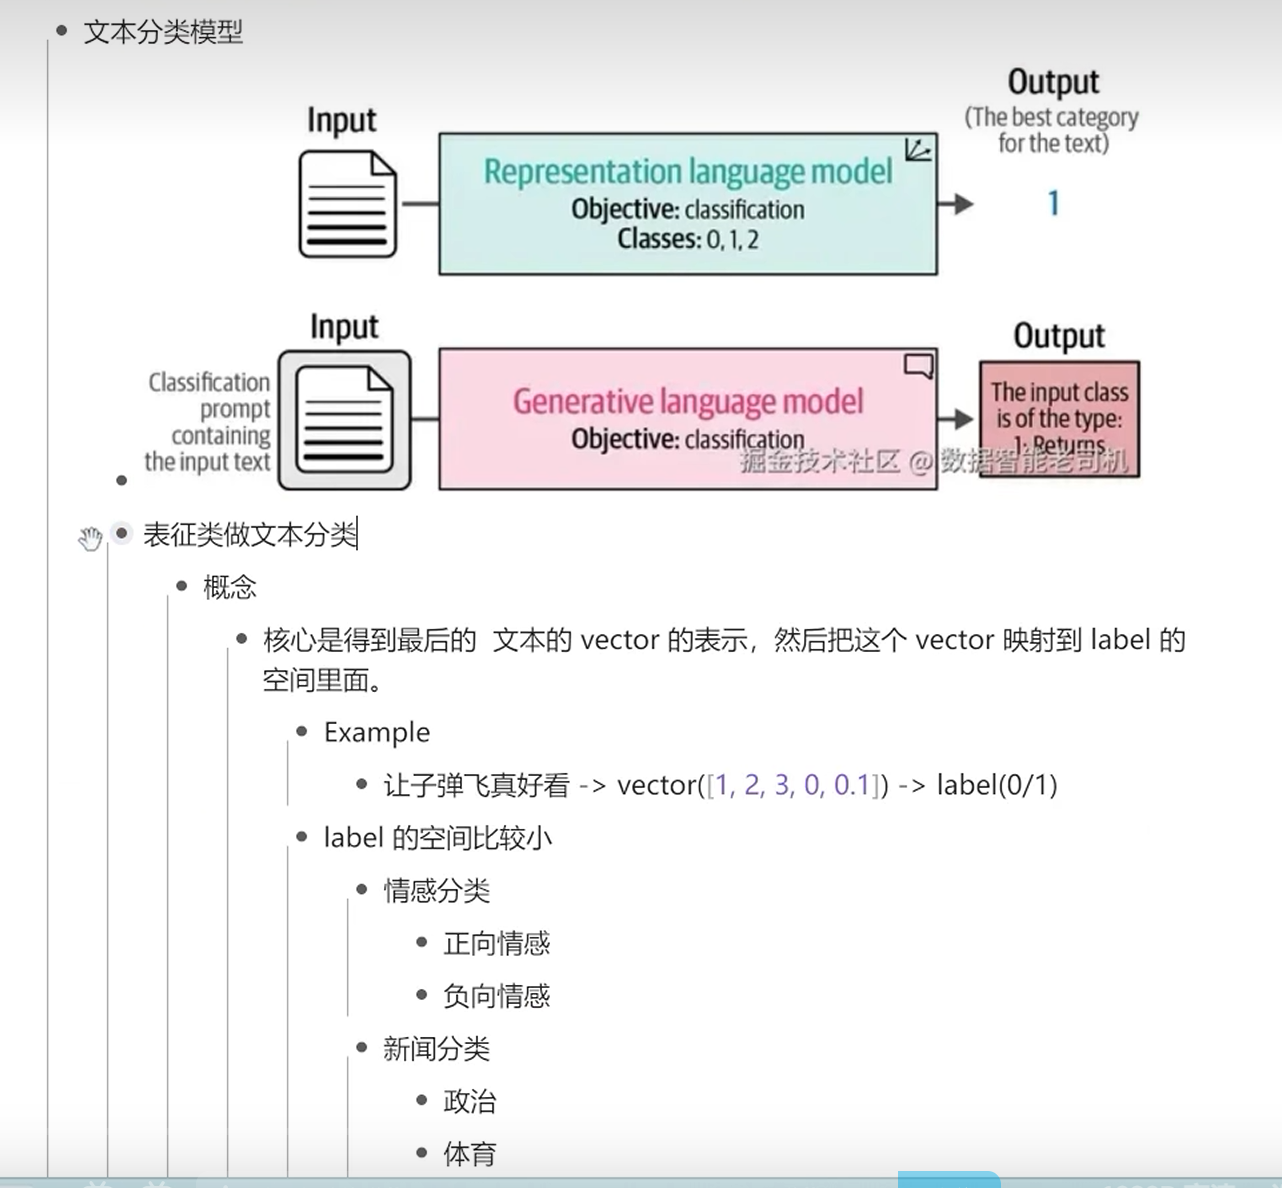
现在有两种方法 一种是表征类进行特征提取然后softmax输出结果

生成类则是大模型直接生成结果

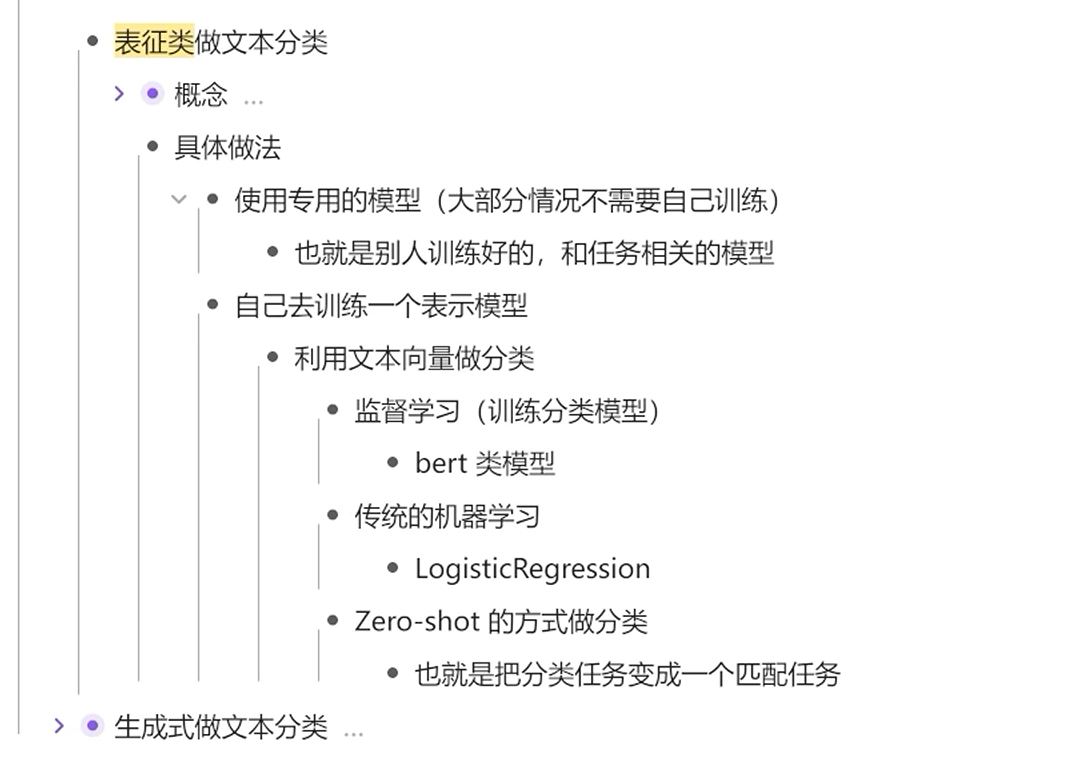
表征类有两种：1、预训练好的模型直接加载来用 2、自己训练模型（监督学习、zero-shot）

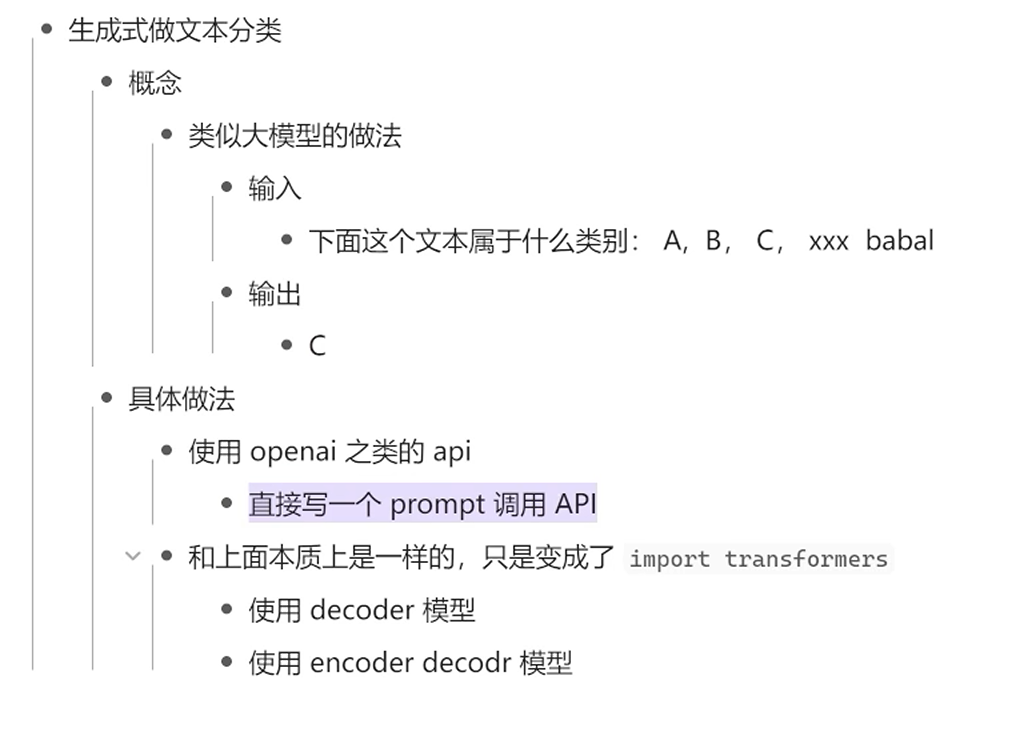

生成式模型：1、调用api 2、使用模型

In [ ]:
# %%capture
# !pip install datasets transformers sentence-transformers openai

In [7]:
import os
os.environ["HF_HOME"] = "/openbayes/home/huggingface"

## 4.1 加载数据

In [8]:
from datasets import load_dataset

# 使用最经典的情感 分类
data = load_dataset("rotten_tomatoes")
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [9]:
data["train"][0, -1]

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
  'things really get weird , though not particularly scary : the movie is all portent and no content .'],
 'label': [1, 0]}

## 4.2 表征类模型(Representation Models)
### 4.2.1 使用和任务相关的模型(task-specific model)

In [10]:
from transformers import pipeline

# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
# Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive
# Path to our HF model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load model into pipeline
pipe = pipeline(
    model=model_path,
    tokenizer=model_path,
    return_all_scores=True,
    device="cuda:0"
)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
import numpy as np
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

# Run inference
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "text")), total=len(data["test"])):
    # pipe 会自动使用 模型内置的 label 3 分类
    negative_score = output[0]["score"]
    positive_score = output[2]["score"]
    assignment = np.argmax([negative_score, positive_score])
    y_pred.append(assignment)


100%|██████████| 1066/1066 [00:07<00:00, 142.24it/s]


In [15]:
from sklearn.metrics import classification_report

def evaluate_performance(y_true, y_pred):
    """Create and print the classification report"""
    performance = classification_report(
        y_true, y_pred,
        target_names=["Negative Review", "Positive Review"]
    )
    print(performance)

In [16]:
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.76      0.88      0.81       533
Positive Review       0.86      0.72      0.78       533

       accuracy                           0.80      1066
      macro avg       0.81      0.80      0.80      1066
   weighted avg       0.81      0.80      0.80      1066



#### 备注：macro/micro avg 的区别？
- macro avg 是针对每个类别算自己的 precision/recall/f1，然后取平均
- micro avg 先计算总体的TP、FP、FN等,然后再计算总体指标。

### 4.2.2 利用文本向量做分类
#### 监督学习（训练分类模型）


In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

# Convert text to embeddings
train_embeddings = model.encode(data["train"]["text"], show_progress_bar=True)
test_embeddings = model.encode(data["test"]["text"], show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/output/envs/hands-on-llm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [21]:
train_embeddings.shape

(8530, 768)

#### 使用传统机器学习分类

In [27]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression on our train embeddings
# 可以调参学习
# 
clf = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    # C=0.1,  # 正则化
)
clf.fit(train_embeddings, data["train"]["label"])

# Predict previously unseen instances
y_pred = clf.predict(test_embeddings)
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.79      0.82      0.80       533
Positive Review       0.81      0.78      0.79       533

       accuracy                           0.80      1066
      macro avg       0.80      0.80      0.80      1066
   weighted avg       0.80      0.80      0.80      1066



#### Zero-shot 方式分类（匹配）

##### 注意 1 ⚠️
我们也可以不学习，直接让模型的表示的  Embedding 和 Label 的 Embedding 进行相似度计算？
- step1: 把所有正(或负）加起来，计算平均；这样就可以得到 正（或负）样本的 embedding （其实和 MF 的思想非常的相似）
- step2: 计算 test sample 中样本 embedding 和正负样本 embedding 的相似度，更接近的那个就是类似
> 本质上是把分类任务变成匹配任务

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

# Average the embeddings of all documents in each target label
df = pd.DataFrame(np.hstack([train_embeddings, np.array(data["train"]["label"]).reshape(-1, 1)]))
print(df.shape, train_embeddings.shape)
averaged_target_embeddings = df.groupby(768).mean().values
print(averaged_target_embeddings.shape)

# Find the best matching embeddings between evaluation documents and target embeddings
sim_matrix = cosine_similarity(test_embeddings, averaged_target_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)

# Evaluate the model
evaluate_performance(data["test"]["label"], y_pred)

(8530, 769) (8530, 768)
(2, 768)
                 precision    recall  f1-score   support

Negative Review       0.74      0.79      0.76       533
Positive Review       0.77      0.73      0.75       533

       accuracy                           0.76      1066
      macro avg       0.76      0.76      0.76      1066
   weighted avg       0.76      0.76      0.76      1066



In [34]:
# 用另外一种方式获取 label 的 embedding
label_embeddings = model.encode(["A negative review",  "A positive review"])


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

# Find the best matching label for each document
sim_matrix = cosine_similarity(test_embeddings, label_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)


evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.75      0.61      0.68       533
Positive Review       0.67      0.80      0.73       533

       accuracy                           0.71      1066
      macro avg       0.71      0.71      0.70      1066
   weighted avg       0.71      0.71      0.70      1066



 比前一个得到中心的方法准确度低，因为显然用正样本嵌入的平均得到结果更为合适

##### 注意 2 ⚠️
label 的描述可以换成其他的描述，比如  "A very negative movie review" 和 "A very positive movie review"


这是一个实验科学，合理的发散和尝试

## 4.3 生成模型做分类
### 4.3.1 Encoder-docer 模型

In [1]:
# Load our model
pipe = pipeline(
    "text2text-generation",
    model="google/flan-t5-small",
    device="cuda:0"
)

# Prepare our data
prompt = "Is the following sentence positive or negative? "
data = data.map(lambda example: {"t5": prompt + example['text']})
data

NameError: name 'pipeline' is not defined

In [41]:
# 推理
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "t5")), total=len(data["test"])):
    text = output[0]["generated_text"]
    y_pred.append(0 if text == "negative" else 1)


100%|██████████| 1066/1066 [00:25<00:00, 41.26it/s]


In [42]:
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.83      0.85      0.84       533
Positive Review       0.85      0.83      0.84       533

       accuracy                           0.84      1066
      macro avg       0.84      0.84      0.84      1066
   weighted avg       0.84      0.84      0.84      1066



#### 备注
这个方式本质上是一种提示学习(prompt learning)，Instruction Tuning和Prompt learning 方法的核心一样，就是去发掘语言模型本身具备的知识。而他们的不同点就在于，Prompt learning是去激发语言模型的补全能力，比如给出上半句生成下半句、或者做完形填空，都还是像在做language model任务，而Instruction Tuning则是激发语言模型的理解能力，通过给出更明显的指令，让模型去理解并做出正确的反馈，是一种微调的方式，通过问题和正确的答案进行组合然后微调

不过现在提 prompt learning 已经比较少了，可以把 prompt leanring 认为是 instruction turning 的子集。

prompt tuning是一种微调的方式，在prompt中加入可以微调软提示来对模型微调 （prefix tuning）


### 4.3.2 Decoder 模型


In [49]:
# Load our model
pipe = pipeline(
    "text-generation",
    model="gpt2",
    device="cuda:0"
)

# Prepare our data
prompt = "Is the following sentence positive or negative? "
data = data.map(lambda example: {"gpt2": prompt + example['text']})
data

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 't5', 'gpt', 'gpt2'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 't5', 'gpt', 'gpt2'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 't5', 'gpt', 'gpt2'],
        num_rows: 1066
    })
})

In [48]:
# 推理
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "gpt2")), total=len(data["test"])):
    text = output[0]["generated_text"]
    y_pred.append(0 if text == "negative" else 1)

evaluate_performance(data["test"]["label"], y_pred)

100%|██████████| 1066/1066 [00:25<00:00, 41.28it/s]

                 precision    recall  f1-score   support

Negative Review       0.00      0.00      0.00       533
Positive Review       0.50      1.00      0.67       533

       accuracy                           0.50      1066
      macro avg       0.25      0.50      0.33      1066
   weighted avg       0.25      0.50      0.33      1066




/output/envs/hands-on-llm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/output/envs/hands-on-llm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/output/envs/hands-on-llm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.3.3 chatGPT 做文本分类 （一般也是 decoder）

In [53]:
import openai

# 如果国内不方便访问 GPT, 可以使用 deepseek 代替
# 充值一块钱用一年。。。
YOUR_KEY_HERE="sk-680f79219dbf4cce9bf796769b179dfe"
BASE_URL="https://api.deepseek.com"
MODEL_NAME="deepseek-chat"

# 海外
# YOUR_KEY_HERE="YOUR_KEY_HERE"
# BASE_URL="https://api.openai.com/v1"
# MODEL_NAME="gpt-3.5-turbo-0125"


client = openai.OpenAI(
    api_key=YOUR_KEY_HERE,
    base_url=BASE_URL
)

def chatgpt_generation(prompt, document, model=MODEL_NAME):
    """Generate an output based on a prompt and an input document."""
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant."
            },
        {
            "role": "user",
            "content":   prompt.replace("[DOCUMENT]", document)
            }
    ]
    chat_completion = client.chat.completions.create(
      messages=messages,
      model=model,
      temperature=0
    )
    return chat_completion.choices[0].message.content

# Define a prompt template as a base
prompt = """Predict whether the following document is a positive or negative movie review:

[DOCUMENT]

If it is positive return 1 and if it is negative return 0. Do not give any other answers.
"""

# Predict the target using GPT
document = "unpretentious , charming , quirky , original"
chatgpt_generation(prompt, document)



'1'

下一步将是针对整个评估数据集运行OpenAI的一个模型。但是，只有当您有足够的令牌时才运行此操作，因为这将为整个测试数据集(1066条记录)调用API。
> 如果没钱就不要🙅‍♂️运行下面的内容

In [54]:
predictions = [chatgpt_generation(prompt, doc) for doc in tqdm(data["test"]["text"])]


100%|██████████| 1066/1066 [11:52<00:00,  1.50it/s]


 准确率最高

In [55]:
# Extract predictions
y_pred = [int(pred) for pred in predictions]

# Evaluate performance
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.89      0.95      0.92       533
Positive Review       0.95      0.88      0.91       533

       accuracy                           0.91      1066
      macro avg       0.92      0.91      0.91      1066
   weighted avg       0.92      0.91      0.91      1066



In [ ]:
print("hello world")